In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = read_csv('Piedecuesta_Lags.csv', encoding='latin-1', sep=";")


# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi','Prom_Dia_Preci','Prom_Dia_Preci_6',
                    'Prom_Dia_Preci_1', 'Prom_Dia_Preci_2', 'Prom_Dia_Preci_4', 'Prom_Dia_Preci_5',
                    'Total_Preci_Sem', 'Total_Preci_Sem_6', 'Total_Preci_Sem_1',
                    'Total_Preci_Sem_2', 'Total_Preci_Sem_4', 'Total_Preci_Sem_5'],axis=1)

datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_3', 'Total_Preci_Sem_3'], dtype='object')

In [3]:
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_3     6
Total_Preci_Sem_3    6
dtype: int64

In [4]:
from sklearn.impute import KNNImputer
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")
knnImputer.fit(datos[['Prom_Dia_Preci_3']])
datos['Prom_Dia_Preci_3'] = knnImputer.transform(datos[['Prom_Dia_Preci_3']]).ravel()
knnImputer.fit(datos[['Total_Preci_Sem_3']])
datos['Total_Preci_Sem_3'] = knnImputer.transform(datos[['Total_Preci_Sem_3']]).ravel()
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_3     0
Total_Preci_Sem_3    0
dtype: int64

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

473 203


In [6]:
f_columns = ['Prom_Dia_Preci_3', 'Total_Preci_Sem_3']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Casos_Dengue, time_steps)
X_test, y_test = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(466, 7, 3) (466,) (196, 7, 3) (196,)


In [10]:
Piede_MLP_model_1 = keras.Sequential()

# CAPA DE ENTRADA
Piede_MLP_model_1.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))

#CAPA DE SALIDA

Piede_MLP_model_1.add(keras.layers.Dense(1))


#COMPILACIÓN DEL MODELO
Piede_MLP_model_1.compile(optimizer="adam", loss = 'mse')


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Piede_MLP_model_3.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_MLP = Piede_MLP_model_1.fit(X_train,y_train, validation_data=(X_test,y_test), 
                                     verbose=2, epochs=100, callbacks=[monitor, checkpoint],shuffle=False)
Piede_MLP_model_1.load_weights(model_filepath)

Epoch 1/100
15/15 - 3s - loss: 0.0461 - val_loss: 0.0124 - 3s/epoch - 194ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0149 - val_loss: 0.0087 - 159ms/epoch - 11ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0178 - val_loss: 0.0110 - 88ms/epoch - 6ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0206 - val_loss: 0.0096 - 93ms/epoch - 6ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0215 - val_loss: 0.0171 - 107ms/epoch - 7ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0195 - val_loss: 0.0059 - 147ms/epoch - 10ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0144 - val_loss: 0.0059 - 160ms/epoch - 11ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0108 - val_loss: 0.0053 - 162ms/epoch - 11ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0089 - val_loss: 0.0051 - 168ms/epoch - 11ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0092 - val_loss: 0.0052 - 96ms/epoch - 6ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0095 - val_loss: 0.0053 - 96ms/epoch - 6ms/step


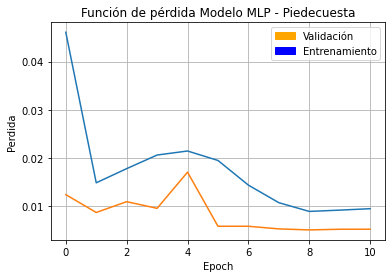

In [11]:
plt.figure(figsize=(6,4))
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo MLP - Piedecuesta')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.show()

In [12]:
y_pred = Piede_MLP_model_1.predict(X_test)
y_train_inv = dengue_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = dengue_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = dengue_transformer.inverse_transform(y_pred.reshape(1, -1))
print(y_train_inv.shape)
print(y_test_inv.shape)
print(y_pred_inv.shape)

7/7 [==============================] - 0s 2ms/step
(1, 466)
(1, 196)
(1, 196)


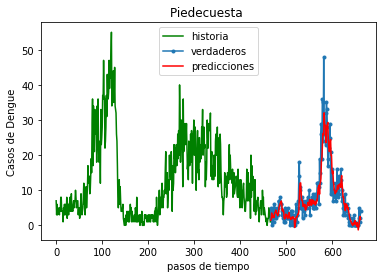

In [13]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="historia")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="verdaderos")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="predicciones")
plt.title('Piedecuesta ')
plt.ylabel('Casos de Dengue')
plt.xlabel('pasos de tiempo')
plt.legend()
plt.show();

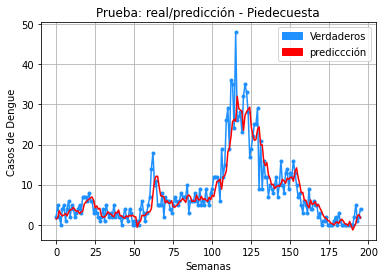

In [14]:
plt.title('Prueba: real/predicción - Piedecuesta' )
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.plot(y_test_inv.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv.flatten(), color= 'red', label="prediccción")
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.show()

In [15]:
score = np.sqrt(metrics.mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("RMSE  Piedecuesta       : {}".format(score))
print("MSE Piedecuesta  = ", mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("MAE Piedecuesta= ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("r2_score Piedecuesta  = ", r2_score(y_test_inv.flatten(), y_pred_inv.flatten()))
print("explained_variance_score Piedecuesta  = ", explained_variance_score(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE  Piedecuesta       : 3.9313051569828987
MSE Piedecuesta  =  15.455160237320333
MAE Piedecuesta=  2.478895238619678
r2_score Piedecuesta  =  0.7778893865165526
explained_variance_score Piedecuesta  =  0.7791538174546829


In [16]:
# VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

resultados = pd.DataFrame({ 'Actuales':y_test_inv.flatten(), 'Predicciones': y_pred_inv.flatten()})
resultados['diferencia'] = resultados['Predicciones'] - resultados['Actuales']
resultados.head(60)

,Actuales,Predicciones,diferencia
0,2.0,1.443792,-0.556208
1,5.0,1.683518,-3.316482
2,2.0,3.520177,1.520177
3,0.0,2.617498,2.617498
4,4.0,2.201390,-1.798610
5,5.0,2.405589,-2.594411
6,1.0,2.798655,1.798655
7,4.0,2.197625,-1.802375
8,6.0,3.165599,-2.834401
9,2.0,3.711334,1.711334


In [17]:
resultados.tail(60)

,Actuales,Predicciones,diferencia
136,7.0,12.483504,5.483504
137,10.0,11.529947,1.529947
138,9.0,9.931549,0.931549
139,8.0,10.118603,2.118603
140,10.0,9.007297,-0.992703
141,12.0,9.463905,-2.536095
142,7.0,9.744179,2.744179
143,10.0,9.568759,-0.431241
144,16.0,10.260929,-5.739071
145,10.0,11.340768,1.340768
